**COMP-5011-FDE Machine Learning & Neural Network**

**Assignment 5**

**Name:** Khushal Paresh Thaker



**Student ID:** 11069**37**

Condition to use Dataset : **CIFAR10** (the last digit of ID belongs to 5-7)

Condition to use pre trained model: **VGG16** (the second last digit of student ID belongs to 3-4)

Run the following Code in Google Colab.

**Requirements:** 

Mount the Google drive.

Use GPU as the runtime.

Create a directory **'vgg16'** in '/content/drive/My Drive' for saving the weights of the transfer learning models which will run 3 times. Also, create a folder **'model2'** in '/content/drive/My Drive/vgg16' so that the weight of learning from scratch model can be saved.

# **Content of the Colab Notebook**
1. Mount Google drive
2. Libraries import
3. cifar10 dataset loading
4. Basic Preprocessing Steps
5. **Task 1:** Transfer Learning Model
    
    a. First Run

    b. Second Run

    c. Third Run

    d. Average accuracies of all three runs

6. **Task 2:** Learning From Scratch Model
7. **Task 3:** Comparising the performance
8. Discussion


Mount Google Drive

In [ ]:
# mounting drive to store the weights of them models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Basic Libraries Import

In [ ]:
#importing libraries
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Input,AveragePooling2D, Activation
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten
# from sklearn.model_selection import train_test_split
import os


Load the cifar10 dataset available from keras

In [ ]:
#loading Dataset
(X_train,y_train),(X_test,y_test) = cifar10.load_data()
print('X train shape',X_train.shape)
print('y train shape',y_train.shape)

170500096/170498071 [==============================] - 2s 0us/step
X train shape (50000, 32, 32, 3)
y train shape (50000, 1)


In [ ]:
#definig image shapes
img_height,img_width,channels = X_train.shape[1],X_train.shape[2],X_train.shape[3]

In [ ]:
# model save directory and other variables
weight_dir = os.path.join(os.getcwd(),'/content/drive/My Drive','vgg16/')
weight_dir
batch_size = 128

In [ ]:
#converting labels to one hot labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print('y train shape after one hot encoding',y_train.shape)
print('y test shape after one hot encoding',y_test.shape)


y train shape after one hot encoding (50000, 10)
y test shape after one hot encoding (10000, 10)


In [ ]:
#using image data generator to generate batch of image arrays and target labels for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# validation split will create a split of 20% for validation data from training dataset
tr_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)
train_generator = tr_datagen.flow(X_train,y_train,batch_size = batch_size)



In [ ]:
#using image data generator to generate batch of image arrays and target labels for validation
val_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = tr_datagen.flow(X_train, y_train,batch_size = batch_size)

# **TASK-1: Transfer Learning Model**

**Transfer Learning Model**

In [ ]:
#defining pretrained model for transfer learning
def pretrained_model():
  vgg16_model = tf.keras.applications.VGG16(
      include_top=False,
      weights="imagenet",
      input_tensor=None,
      input_shape=(img_height,img_width,channels),
      pooling=None,
      classes=None,
      classifier_activation="softmax",
  )
  x = vgg16_model.output
  x = Flatten()(x)
  x = Dropout(0.5)(x)
  x = Dense(units=64,activation='relu')(x)
  x = Dense(units=32,activation='relu')(x)
  x = Dropout(0.5)(x)


  pred=Dense(10,activation='softmax')(x)
  pretrained_model = Model(inputs = vgg16_model.input,outputs = pred)

  pretrained_model.summary()
  return pretrained_model



1.   **Transfer Learning Model**
    
    a. First Run





In [ ]:
#loading Model
pre_trained_model1 = pretrained_model()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_______________________________________________________

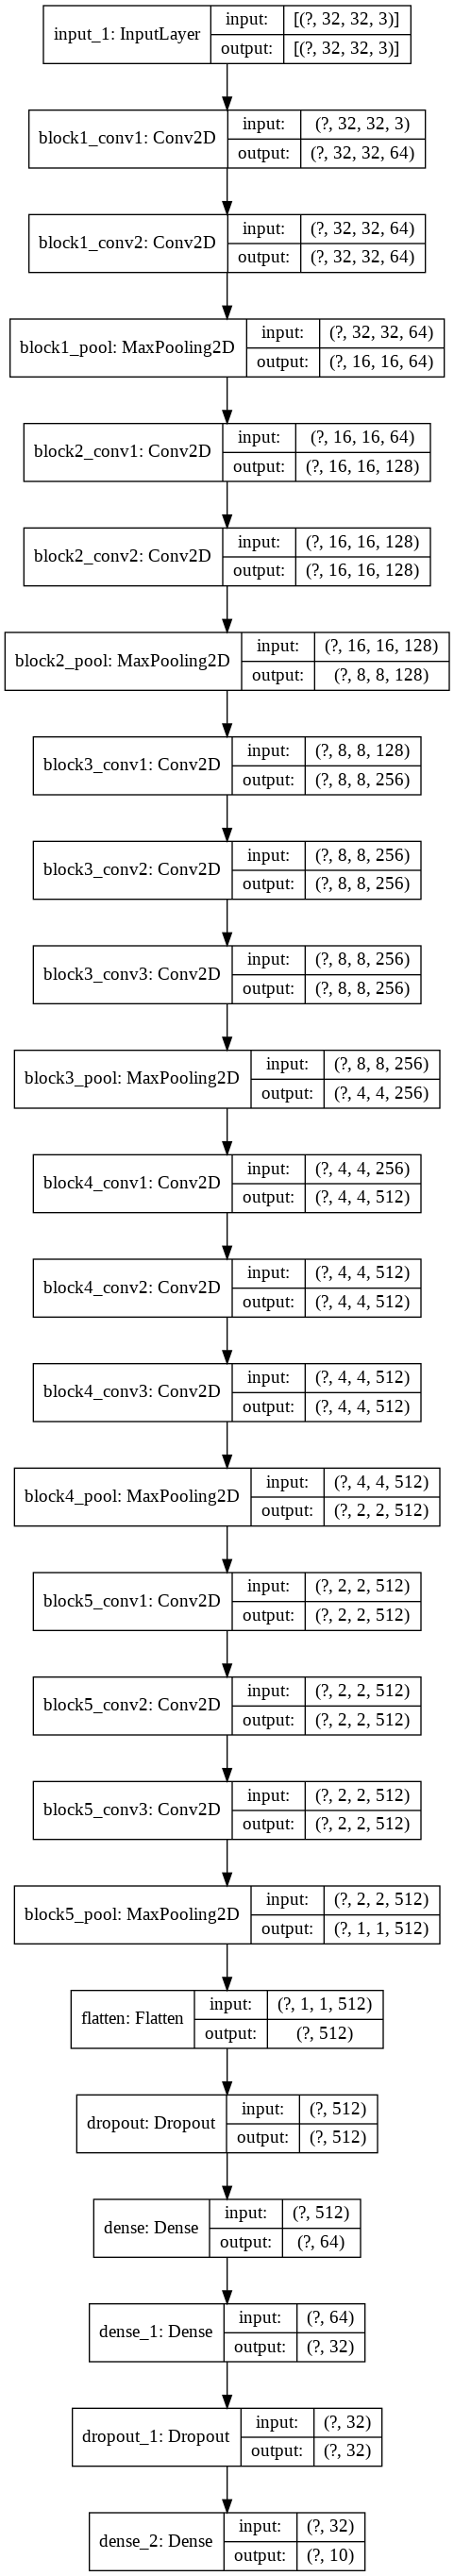

In [ ]:
#plotting the first model
tf.keras.utils.plot_model(pre_trained_model1,'model1.png',show_shapes=True)

In [ ]:
#compiling the model
pre_trained_model1.compile(optimizer=Adam(1e-4) ,loss = 'categorical_crossentropy' ,metrics=['accuracy'])
#pretrained_model.load_weights("/content/drive/My Drive/saved_models/weights.34-0.34.hdf5")

In [80]:
pre_trained_model1.save("tl1_model.h5") # saving model

In [ ]:
#defining callbacks for training
from tensorflow.keras.callbacks import ReduceLROnPlateau,LearningRateScheduler,EarlyStopping,ModelCheckpoint
import os,datetime
import numpy as np


checkpoint = ModelCheckpoint(filepath = os.path.join(weight_dir,'checkpoint1.hdf5'),monitor = 'val_accuracy',verbose=1,save_best_only=True,mode='max'
                             ,save_weights_only=True)


log_dir = os.path.join( 
            "logs",
            "fit",
            datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=np.sqrt(0.1),
                               patience=5,
                               min_lr=0.5e-6,verbose=1, mode='max')

earlystop =tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, verbose=1, mode='max', baseline=0.86)


callbacks = [checkpoint,reduce_lr,earlystop]

In [ ]:
#fitting model
history = pre_trained_model1.fit(train_generator,validation_data=valid_generator,verbose=1,workers=-1,callbacks=callbacks,epochs = 15)

Epoch 1/15
391/391 [==============================] - ETA: 0s - loss: 2.2224 - accuracy: 0.1544
Epoch 00001: val_accuracy improved from -inf to 0.25976, saving model to /content/drive/My Drive/vgg16/checkpoint1.hdf5
391/391 [==============================] - 28s 73ms/step - loss: 2.2224 - accuracy: 0.1544 - val_loss: 1.9326 - val_accuracy: 0.2598
Epoch 2/15
391/391 [==============================] - ETA: 0s - loss: 1.9760 - accuracy: 0.2621
Epoch 00002: val_accuracy improved from 0.25976 to 0.55292, saving model to /content/drive/My Drive/vgg16/checkpoint1.hdf5
391/391 [==============================] - 29s 73ms/step - loss: 1.9760 - accuracy: 0.2621 - val_loss: 1.5186 - val_accuracy: 0.5529
Epoch 3/15
391/391 [==============================] - ETA: 0s - loss: 1.5966 - accuracy: 0.4242
Epoch 00003: val_accuracy improved from 0.55292 to 0.68012, saving model to /content/drive/My Drive/vgg16/checkpoint1.hdf5
391/391 [==============================] - 29s 74ms/step - loss: 1.5966 - accura

In [ ]:
np.mean(history.history['accuracy']) # numpy assumed imported as np

0.7251599987347921

In [ ]:
history.history['accuracy'][14] # training accuracy of the model for the last epoch

0.9526000022888184

In [ ]:
#plotting loss and accuracies
import matplotlib.pyplot as plt

def plot_summary(history):
  plt.figure(figsize=(12,7))

  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.scatter(x = [i for i in range(len(history.history['accuracy']))],y = history.history['accuracy'])

  plt.plot(history.history['val_accuracy'])
  plt.scatter(x = [i for i in range(len(history.history['val_accuracy']))],y = history.history['val_accuracy'])

  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
  plt.figure(figsize=(12,7))

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.scatter(x = [i for i in range(len(history.history['loss']))],y = history.history['loss'])

  plt.plot(history.history['val_loss'])
  plt.scatter(x = [i for i in range(len(history.history['val_loss']))],y = history.history['val_loss'])

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.grid()
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

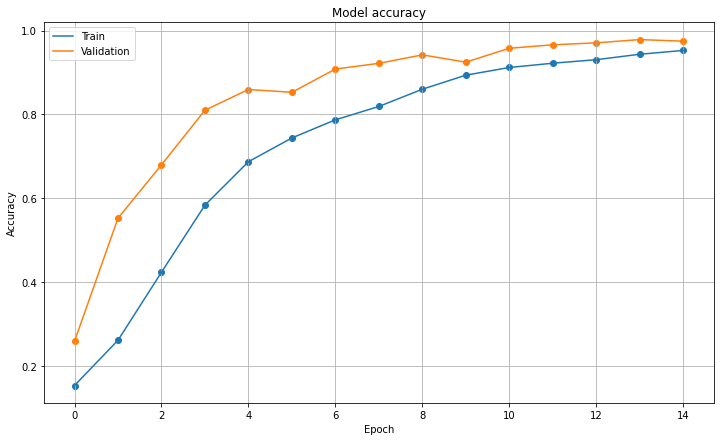

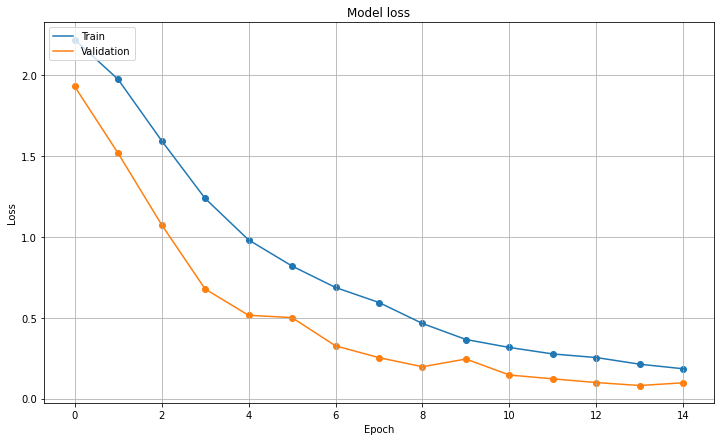

In [ ]:
plot_summary(history)

1.   **Transfer Learning Model**
    
    b. Second Run

In [ ]:
#defining the transfer learning model for second run
pre_trained_model2 = pretrained_model()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

In [ ]:
#compiling second model
pre_trained_model2.compile(optimizer=Adam(1e-4) ,loss = 'categorical_crossentropy' ,metrics=['accuracy'])
#pretrained_model.load_weights("/content/drive/My Drive/saved_models/weights.34-0.34.hdf5")

In [79]:
pre_trained_model2.save("tl2_model.h5") # saving model

In [ ]:
#defining callbacks for training

checkpoint = ModelCheckpoint(filepath = os.path.join(weight_dir,'checkpoint2.hdf5'),monitor = 'val_accuracy',verbose=1,save_best_only=True,mode='max'
                             ,save_weights_only=True)


log_dir = os.path.join( 
            "logs",
            "fit",
            datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=np.sqrt(0.1),
                               patience=5,
                               min_lr=0.5e-6,verbose=1, mode='max')

earlystop =tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, verbose=1, mode='max', baseline=0.86)

callbacks = [checkpoint,reduce_lr,earlystop]

In [ ]:
#fitting transfer learning model for second run
history2 = pre_trained_model2.fit(train_generator,validation_data=valid_generator,verbose=1,workers=-1,callbacks=callbacks,epochs = 15)

Epoch 1/15
391/391 [==============================] - ETA: 0s - loss: 1.8232 - accuracy: 0.3479
Epoch 00001: val_accuracy improved from -inf to 0.70594, saving model to /content/drive/My Drive/vgg16/checkpoint2.hdf5
391/391 [==============================] - 29s 74ms/step - loss: 1.8232 - accuracy: 0.3479 - val_loss: 0.9881 - val_accuracy: 0.7059
Epoch 2/15
391/391 [==============================] - ETA: 0s - loss: 1.0809 - accuracy: 0.6643
Epoch 00002: val_accuracy improved from 0.70594 to 0.82236, saving model to /content/drive/My Drive/vgg16/checkpoint2.hdf5
391/391 [==============================] - 29s 74ms/step - loss: 1.0809 - accuracy: 0.6643 - val_loss: 0.5863 - val_accuracy: 0.8224
Epoch 3/15
391/391 [==============================] - ETA: 0s - loss: 0.8159 - accuracy: 0.7593
Epoch 00003: val_accuracy improved from 0.82236 to 0.85720, saving model to /content/drive/My Drive/vgg16/checkpoint2.hdf5
391/391 [==============================] - 29s 75ms/step - loss: 0.8159 - accura

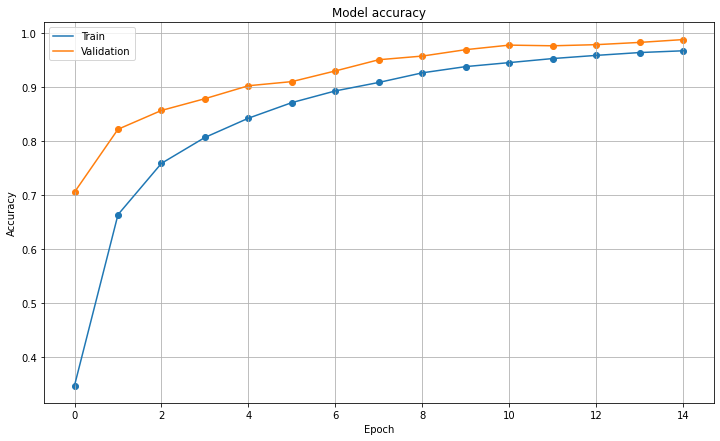

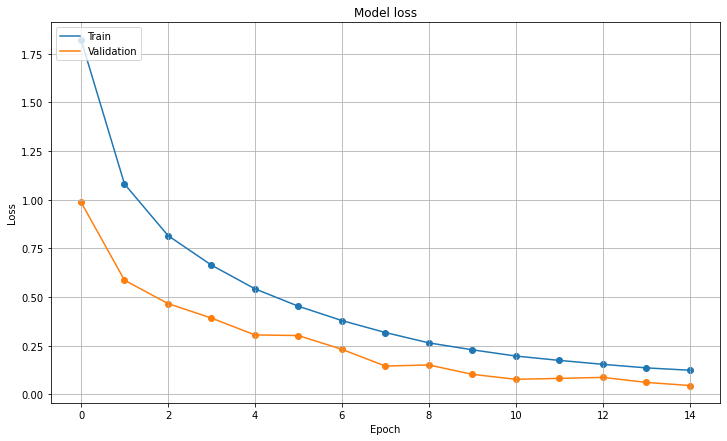

In [66]:
#plotting loss and accuracy
plot_summary(history2)

In [ ]:
np.mean(history2.history['accuracy'])

0.8500706712404887

In [ ]:
history2.history['accuracy'][14]

0.9676399827003479

1.   **Transfer Learning Model**
    
    c. Third Run

In [ ]:
#definig 3rd model
tf.keras.backend.clear_session()
pre_trained_model3 = pretrained_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)        

In [ ]:
#compiling it
pre_trained_model3.compile(optimizer=Adam(1e-4) ,loss = 'categorical_crossentropy' ,metrics=['accuracy'])
#pretrained_model.load_weights("/content/drive/My Drive/saved_models/weights.34-0.34.hdf5")

In [ ]:
#defining callbacks for training

checkpoint = ModelCheckpoint(filepath = os.path.join(weight_dir,'checkpoint3.hdf5'),monitor = 'val_accuracy',verbose=1,save_best_only=True,mode='max'
                             ,save_weights_only=True)


log_dir = os.path.join( 
            "logs",
            "fit",
            datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=np.sqrt(0.1),
                               patience=5,
                               min_lr=0.5e-6,verbose=1, mode='max')

earlystop =tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, verbose=1, mode='max', baseline=0.86)

callbacks = [checkpoint,reduce_lr,earlystop]

In [78]:
pre_trained_model1.save("tl3_model.h5") # saving model

In [ ]:
#fitting 3rd model
history3 = pre_trained_model3.fit(train_generator,validation_data=valid_generator,verbose=1,workers=-1,callbacks=callbacks,epochs = 15
                               )

Epoch 1/15
391/391 [==============================] - ETA: 0s - loss: 1.6330 - accuracy: 0.4451
Epoch 00001: val_accuracy improved from -inf to 0.73102, saving model to /content/drive/My Drive/vgg16/checkpoint3.hdf5
391/391 [==============================] - 29s 74ms/step - loss: 1.6330 - accuracy: 0.4451 - val_loss: 0.9110 - val_accuracy: 0.7310
Epoch 2/15
391/391 [==============================] - ETA: 0s - loss: 1.0246 - accuracy: 0.6979
Epoch 00002: val_accuracy improved from 0.73102 to 0.82458, saving model to /content/drive/My Drive/vgg16/checkpoint3.hdf5
391/391 [==============================] - 29s 74ms/step - loss: 1.0246 - accuracy: 0.6979 - val_loss: 0.6216 - val_accuracy: 0.8246
Epoch 3/15
391/391 [==============================] - ETA: 0s - loss: 0.7978 - accuracy: 0.7691
Epoch 00003: val_accuracy improved from 0.82458 to 0.85970, saving model to /content/drive/My Drive/vgg16/checkpoint3.hdf5
391/391 [==============================] - 29s 74ms/step - loss: 0.7978 - accura

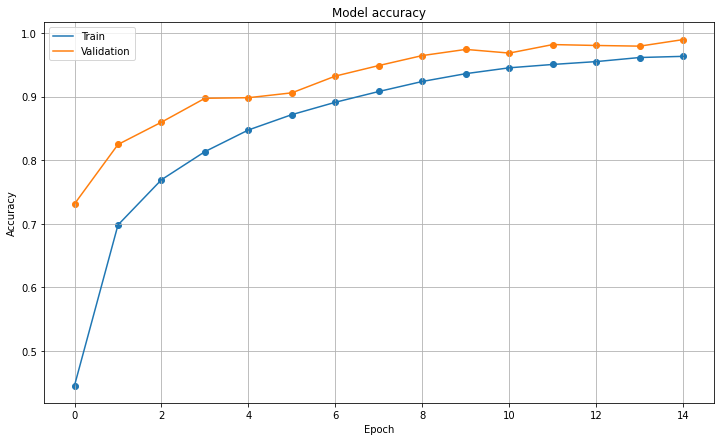

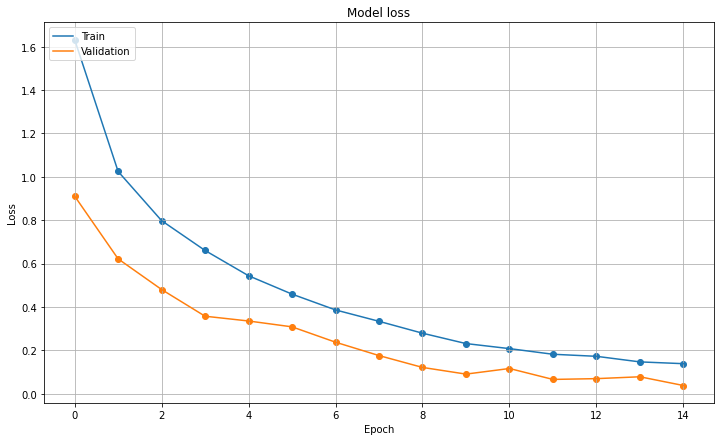

In [67]:
#sumary for 3rd model
plot_summary(history3)

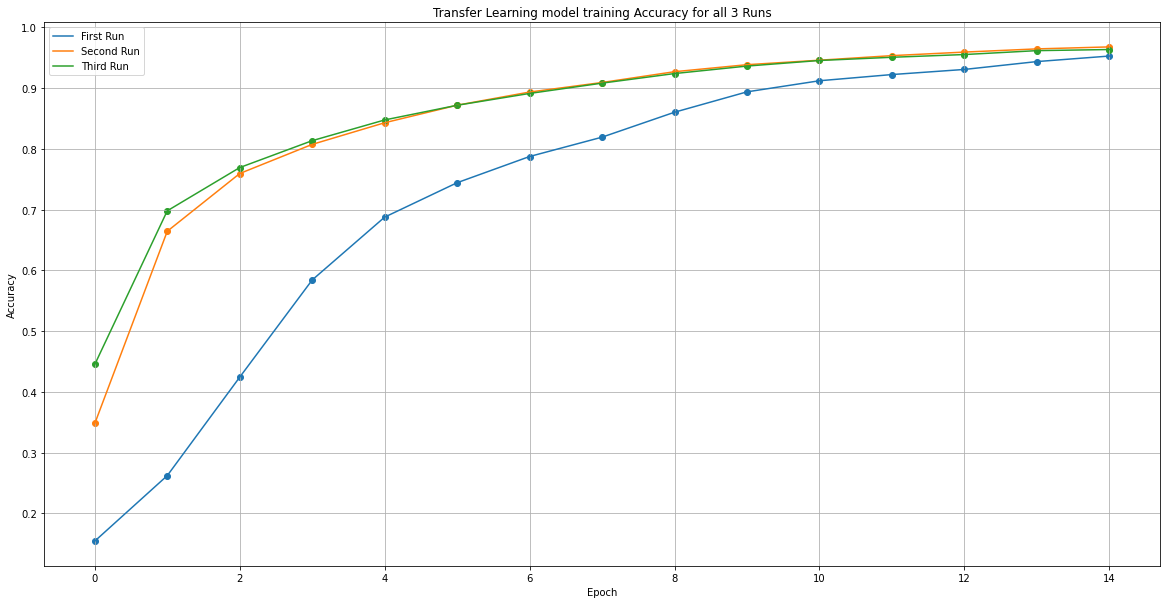

In [ ]:
# Plotting training accuracy values
plt.figure(figsize=(20,10))
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.scatter(x = [i for i in range(len(history.history['accuracy']))],y = history.history['accuracy'])#scatter plots for acc/loss at given epoch
plt.plot(history2.history['accuracy'])
plt.scatter(x = [i for i in range(len(history2.history['accuracy']))],y = history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.scatter(x = [i for i in range(len(history3.history['accuracy']))],y = history3.history['accuracy'])
plt.title('Transfer Learning model training Accuracy for all 3 Runs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['First Run', 'Second Run','Third Run'], loc='upper left')
plt.show()

In [ ]:
np.mean(history3.history['accuracy'])

0.8586173276106517

In [ ]:
history3.history['accuracy'][14]

0.9633399844169617

1.   **Transfer Learning Model**
    
    d. Average of Training and Testing Accuracies for 3 runs 

In [ ]:
(((history.history['accuracy'][14])+(history2.history['accuracy'][14])+(history3.history['accuracy'][14]))/3)*100

96.1193323135376

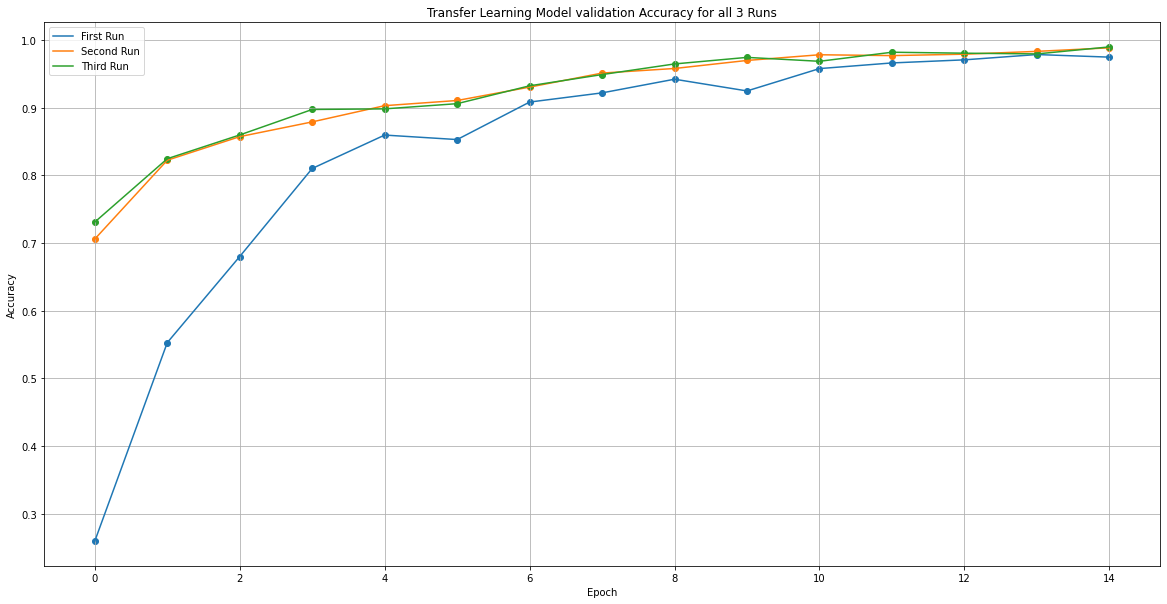

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(20,10))
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'])
plt.scatter(x = [i for i in range(len(history.history['val_accuracy']))],y = history.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.scatter(x = [i for i in range(len(history2.history['val_accuracy']))],y = history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.scatter(x = [i for i in range(len(history3.history['val_accuracy']))],y = history3.history['val_accuracy'])
plt.title('Transfer Learning Model validation Accuracy for all 3 Runs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['First Run', 'Second Run','Third Run'], loc='upper left')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(X_test, y_test,batch_size = batch_size)

Loading Transfer Learning Model which was saved 

In [81]:
from keras.models import load_model
tl1_model_test = load_model('/content/tl1_model.h5')
tl2_model_test = load_model('/content/tl2_model.h5')
tl3_model_test = load_model('/content/tl3_model.h5')

Checking testing accuracies by loading model

In [85]:
# pre_trained_model1.load_weights(os.path.join(weight_dir,'checkpoint1.hdf5'))#loading weight of a model
# #testing model1
score_tl1_test = tl1_model_test.evaluate_generator(test_generator,
                        verbose=1,workers=-1,callbacks = callbacks)
print('Test loss for first run by loading the saved model :', score_tl1_test[0])
print('Test accuracy for first run by loading the saved model :', score_tl1_test[1])

79/79 [==============================] - 1s 19ms/step - loss: 0.7522 - accuracy: 0.8573
Test loss for first run by loading the saved model : 0.7521984577178955
Test accuracy for first run by loading the saved model : 0.8572999835014343


In [86]:
# pre_trained_model1.load_weights(os.path.join(weight_dir,'checkpoint1.hdf5'))#loading weight of a model
# #testing model1
score_tl2_test = tl2_model_test.evaluate_generator(test_generator,
                        verbose=1,workers=-1,callbacks = callbacks)
print('Test loss for second run by loading the saved model :', score_tl2_test[0])
print('Test accuracy for second run by loading the saved model :', score_tl2_test[1])

79/79 [==============================] - 1s 19ms/step - loss: 0.9187 - accuracy: 0.8600
Test loss for second run by loading the saved model : 0.9187353253364563
Test accuracy for second run by loading the saved model : 0.8600000143051147


In [87]:
# pre_trained_model1.load_weights(os.path.join(weight_dir,'checkpoint1.hdf5'))#loading weight of a model
# #testing model1
score_tl3_test = tl3_model_test.evaluate_generator(test_generator,
                        verbose=1,workers=-1,callbacks = callbacks)
print('Test loss for Third run by loading the saved model :', score_tl3_test[0])
print('Test accuracy for Third run by loading the saved model :', score_tl3_test[1])

79/79 [==============================] - 1s 19ms/step - loss: 0.7522 - accuracy: 0.8573
Test loss for Third run by loading the saved model : 0.7521982192993164
Test accuracy for Third run by loading the saved model : 0.8572999835014343


Checking Accuracies by using the weights saved

In [ ]:
pre_trained_model1.load_weights(os.path.join(weight_dir,'checkpoint1.hdf5'))#loading weight of a model
#testing model1
score1 = pre_trained_model1.evaluate_generator(test_generator,
                        verbose=1,workers=-1,callbacks = callbacks)
print('Test loss for first run:', score1[0])
print('Test accuracy for first run:', score1[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
79/79 [==============================] - 2s 20ms/step - loss: 0.7522 - accuracy: 0.8573
Test loss for first run: 0.7521984577178955
Test accuracy for first run: 0.8572999835014343


In [ ]:
pre_trained_model2.load_weights(os.path.join(weight_dir,'checkpoint2.hdf5'))#loading weights of model2

#testing model2
score2 = pre_trained_model2.evaluate_generator(test_generator,
                        verbose=1,workers=-1,callbacks = callbacks)
print('Test loss for second run:', score2[0])
print('Test accuracy for second run:', score2[1])

79/79 [==============================] - 1s 17ms/step - loss: 0.9187 - accuracy: 0.8600
Test loss for second run: 0.9187352657318115
Test accuracy for second run: 0.8600000143051147


In [ ]:
pre_trained_model3.load_weights(os.path.join(weight_dir,'checkpoint3.hdf5'))
#testing model3
score3 = pre_trained_model3.evaluate_generator(test_generator,
                        verbose=1,workers=-1,callbacks = callbacks)
print('Test loss for third run:', score3[0])
print('Test accuracy for third run:', score3[1])

79/79 [==============================] - 1s 17ms/step - loss: 0.7465 - accuracy: 0.8611
Test loss for third run: 0.7465143799781799
Test accuracy for third run: 0.8611000180244446


In [ ]:
#Averaging Testing scores of all the three Runs
avg = (score1[1]+score2[1]+score3[1])/3
print('Average test accuracies are: {:.3f} %'.format(avg*100))

Average test accuracies are: 85.947 %


# **TASK-2: Learn From Scratch Model**

**Learning From Scratch Model**

In [ ]:
#Defining the model architecture for Learning from Scratch

from tensorflow.keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D
tf.keras.backend.clear_session()


input_layer = Input(shape = ((img_height,img_width,channels)))

# block 1
x = Conv2D(64, (3, 3),activation='relu', padding='same')(input_layer)
x = Dropout(0.4)(x)

x = Conv2D(64, (3, 3),activation='relu', padding='same')(x)

x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

# block 2
x = Conv2D(128, (3, 3),activation='relu', padding='same')(x)
x = Dropout(0.4)(x)

x = Conv2D(128, (3, 3),activation='relu', padding='same')(x)

x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
# block 3
x = Conv2D(256, (3, 3),activation='relu', padding='same')(x)
x = Dropout(0.4)(x)
x = Conv2D(256, (3, 3),activation='relu', padding='same')(x)
x = Dropout(0.4)(x)
x = Conv2D(256, (3, 3),activation='relu', padding='same')(x)

x = Dropout(0.4)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
# block 4
x = Conv2D(512, (3, 3),activation='relu', padding='same')(x)
x = Dropout(0.4)(x)

x = Conv2D(512, (3, 3),activation='relu', padding='same')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)

x = Conv2D(512, (3, 3),activation='relu', padding='same')(x)

x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = Conv2D(512, (3, 3),activation='relu', padding='same')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)

x = Conv2D(512, (3, 3),activation='relu', padding='same')(x)
x = Dropout(0.4)(x)

x = Conv2D(512, (3, 3),activation='relu', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(filters=64,kernel_size=(2,2),strides=(1,1),data_format='channels_last',
           activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0))(x)
x = Dropout(0.4)(x)

x = BatchNormalization()(x)

x = Conv2D(filters=32,kernel_size=(1,1),strides=(1,1),data_format='channels_last',
           activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0))(x)
x = Dropout(0.4)(x)

x = Flatten()(x)

x = BatchNormalization()(x)

pred=Dense(10,activation='softmax')(x)
model2 = Model(inputs = input_layer,outputs = pred)

model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 128)      

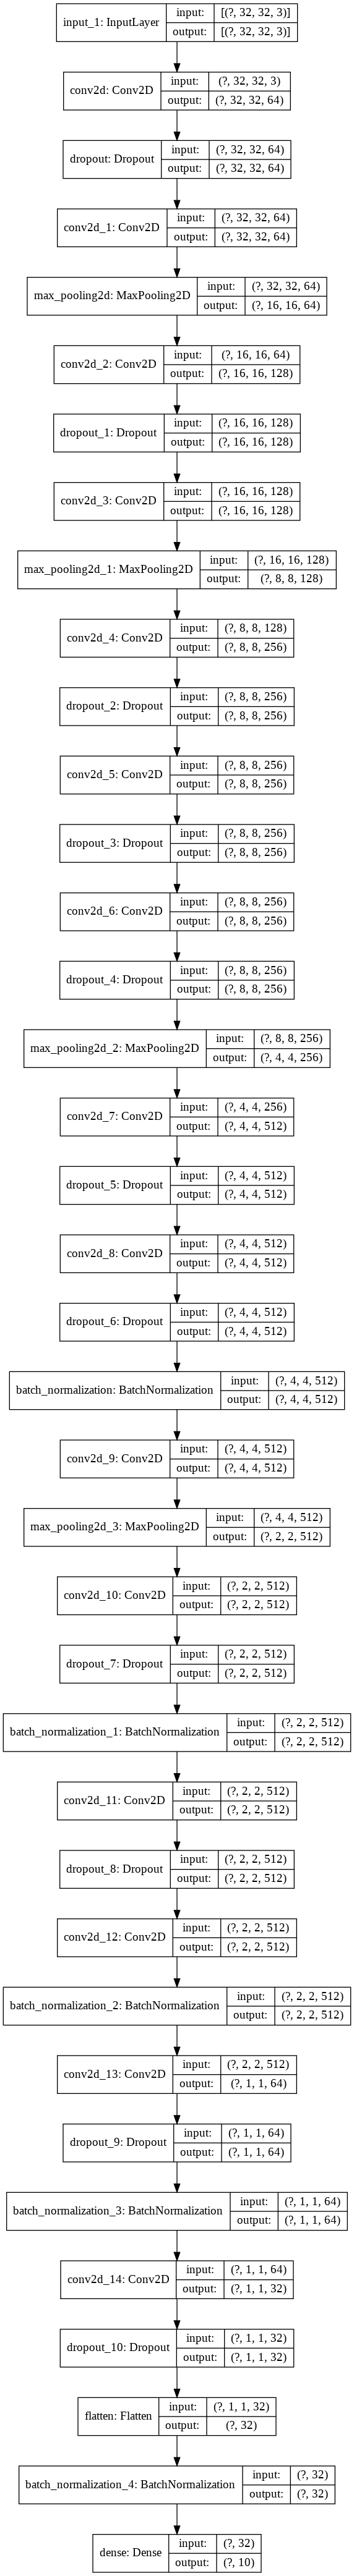

In [ ]:
#plotting the model
tf.keras.utils.plot_model(model2,'model2.png',show_shapes=True)

In [ ]:
#compiling the model
model2.compile(optimizer=Adam(0.0001) ,loss = 'categorical_crossentropy' ,metrics=['accuracy'])
#model2.load_weights(os.path.join(weight_dir,'model2/checkpoint.hdf5'))

In [88]:
model2.save('lfs_model.h5') #save model

In [ ]:
#defining callbacks for training the learn from scratch model

from tensorflow.keras.callbacks import ReduceLROnPlateau,LearningRateScheduler,EarlyStopping,ModelCheckpoint
import os,datetime
import numpy as np


checkpoint2 = ModelCheckpoint(filepath = os.path.join(weight_dir,'model2/checkpoint.hdf5'),monitor = 'val_accuracy',verbose=1,save_best_only=True,mode='max'
                             ,save_weights_only=True)

reduce_lr2 = ReduceLROnPlateau(monitor='val_accuracy', factor=np.sqrt(0.1),
                               patience=7,
                               min_lr=0.5e-6,verbose=1, mode='max')

earlystop2 = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='max')

callbacks2 = [checkpoint2,reduce_lr2,earlystop2]

In [ ]:
#trinaing the model from scratch
hist_scratch = model2.fit(train_generator,validation_data=valid_generator,verbose=1,workers=-1,callbacks=callbacks2,epochs = 125)

Epoch 1/125
391/391 [==============================] - ETA: 0s - loss: 2.6124 - accuracy: 0.1366
Epoch 00001: val_accuracy improved from -inf to 0.10004, saving model to /content/drive/My Drive/vgg16/model2/checkpoint.hdf5
391/391 [==============================] - 32s 81ms/step - loss: 2.6124 - accuracy: 0.1366 - val_loss: 3.1356 - val_accuracy: 0.1000
Epoch 2/125
391/391 [==============================] - ETA: 0s - loss: 2.3109 - accuracy: 0.1772
Epoch 00002: val_accuracy did not improve from 0.10004
391/391 [==============================] - 31s 79ms/step - loss: 2.3109 - accuracy: 0.1772 - val_loss: 5.5837 - val_accuracy: 0.0999
Epoch 3/125
391/391 [==============================] - ETA: 0s - loss: 2.1990 - accuracy: 0.1968
Epoch 00003: val_accuracy did not improve from 0.10004
391/391 [==============================] - 30s 78ms/step - loss: 2.1990 - accuracy: 0.1968 - val_loss: 3.2604 - val_accuracy: 0.0919
Epoch 4/125
391/391 [==============================] - ETA: 0s - loss: 2.1

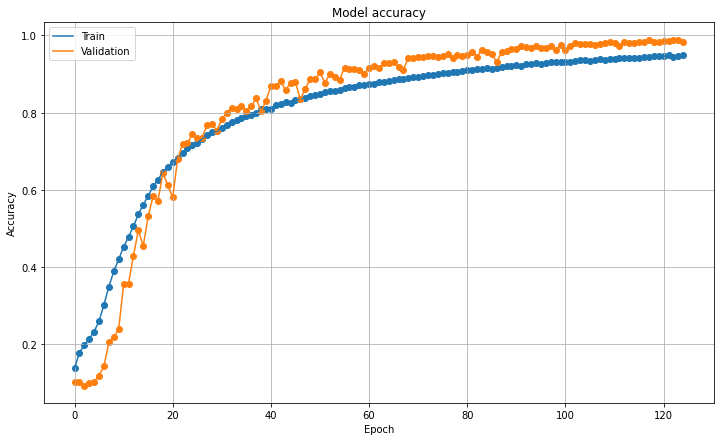

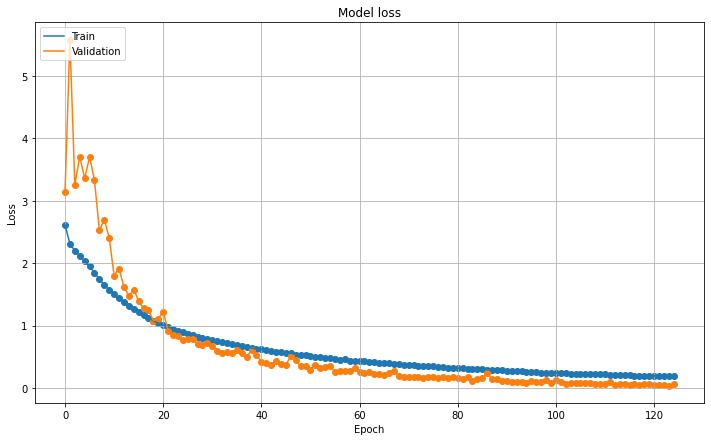

In [68]:
#plotting summary
plot_summary(hist_scratch)

Test accuracy with loading model

In [89]:
lfs_model_test = load_model('/content/lfs_model.h5') #loading model
#testing on test data
lfs_score_test = lfs_model_test.evaluate_generator(test_generator,
                        verbose=1,workers=-1,callbacks = callbacks2)
print('Test loss with loaded model:', lfs_score_test[0])
print('Test accuracy with loaded model:', lfs_score_test[1])

79/79 [==============================] - 1s 19ms/step - loss: 0.5767 - accuracy: 0.8656
Test loss with loaded model: 0.576704740524292
Test accuracy with loaded model: 0.8655999898910522


Accuracy Prediction by Loading the weights

In [ ]:
#loading model weights
model2.load_weights(os.path.join(weight_dir,'model2/checkpoint.hdf5'))

In [ ]:
#testing on test data
score = model2.evaluate_generator(test_generator,
                        verbose=1,workers=-1,callbacks = callbacks2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

79/79 [==============================] - 2s 20ms/step - loss: 0.5767 - accuracy: 0.8656
Test loss: 0.5767048001289368
Test accuracy: 0.8655999898910522


In [ ]:
hist_scratch.history['accuracy'][124] # 125th epoch accuracy

0.9493600130081177

In [ ]:
np.mean(hist_scratch.history['accuracy']) # numpy assumed imported as np

0.8004679992198944

# **TASK-3: COMPARING MODELS:**

Comparison of Accuracies for Transfer Learning and Learn from Scratch models

In [ ]:
print("Transfer Learning Model")
print("Average Training Accuracy of Transfer Learning Model for 3 runs:",(((history.history['accuracy'][14])+(history2.history['accuracy'][14])+(history3.history['accuracy'][14]))/3)*100)
print("Average Testing Accuracy of Transfer Learning Model for 3 runs:",((score1[1]+score2[1]+score3[1])/3)*100)
print("Learn From Scratch Model")
print("Training Accuracy of Learn From Scratch Model for 1 run:",(hist_scratch.history['accuracy'][124]*100))
print("Testing Accuracy of Learn From Scratch Model for 1 run:",(score[1]*100))


Transfer Learning Model
Average Training Accuracy of Transfer Learning Model for 3 runs: 96.1193323135376
Average Testing Accuracy of Transfer Learning Model for 3 runs: 85.94666719436646
Learn From Scratch Model
Training Accuracy of Learn From Scratch Model for 1 run: 94.93600130081177
Testing Accuracy of Learn From Scratch Model for 1 run: 86.55999898910522


Discussion

* For the pre trained model it roughly took 15 epochs to reach the desired test accuracy of 85%. But fot the model which had to be trained from the scratch it took 125 epochs which is roughly 8 times more .

* The pretrained models needed less hyperparameter tunig as compared to the learn from scratch model. Learn from scratch took lot of time and effort to tune and get to the desired accuracy.

* Also, it took more time to fit the vgg16 from scratch than the pretrained model.

* In general both types of models were overfitting but the learn from scratch was overfitting a lott than compared with the pre trained one because the pretrained has already learned all the features from the imagenet dataset so it doesent need to learn much or to change their weights much , wherre as other has to learn everything, every relation from scratch so it will perfectly learn only the train data due to high number of filters that this model uses.

* The other cause of overfitting could also be the small size of images (32*32*3). The vgg16 models has very large filter size it can easily learn the underlying relation between the input and target variable.

* Even though the weights used by  pretrained model is from different type of dataset it has been successfully used for this problem by just changing the last fully connected layers.

* Training accuracies have been increased to over 85% for both the transfer learning model and the learn from scratch model.